In [2]:
import random
from typing import Union

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import transformers

# ######################## PART 1: PROVIDED CODE ########################

def load_datasets(data_directory: str) -> Union[dict, dict]:
    """
    Reads the training and validation splits from disk and load
    them into memory.

    Parameters
    ----------
    data_directory: str
        The directory where the data is stored.
    
    Returns
    -------
    train: dict
        The train dictionary with keys 'premise', 'hypothesis', 'label'.
    validation: dict
        The validation dictionary with keys 'premise', 'hypothesis', 'label'.
    """
    import json
    import os

    with open(os.path.join(data_directory, "train.json"), "r") as f:
        train = json.load(f)

    with open(os.path.join(data_directory, "validation.json"), "r") as f:
        valid = json.load(f)

    return train, valid


class NLIDataset(torch.utils.data.Dataset):
    def __init__(self, data_dict: dict):
        self.data_dict = data_dict
        dd = data_dict

        if len(dd["premise"]) != len(dd["hypothesis"]) or len(dd["premise"]) != len(
            dd["label"]
        ):
            raise AttributeError("Incorrect length in data_dict")

    def __len__(self):
        return len(self.data_dict["premise"])

    def __getitem__(self, idx):
        dd = self.data_dict
        return dd["premise"][idx], dd["hypothesis"][idx], dd["label"][idx]


def train_distilbert(model, loader, device):
    model.train()
    criterion = model.get_criterion()
    total_loss = 0.0
    train_accuracy = []
    for premise, hypothesis, target in tqdm(loader):
        optimizer.zero_grad()

        inputs = model.tokenize(premise, hypothesis).to(device)
        target = target.to(device, dtype=torch.float32)
        #print(inputs)
        pred = model(inputs)
        #print(pred)
        #print(target)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print("training accuracy is ")
    accuracy = torch.eq(target, pred.round())
    true_count = 0
    all_count = 0
    # Loop through each element
    for element in accuracy:
        all_count += 1
        if element:  # Check if element is True
             true_count += 1
    print(true_count/all_count)
    return total_loss / len(loader), true_count/all_count


@torch.no_grad()
def eval_distilbert(model, loader, device):
    model.eval()
    criterion = model.get_criterion()
    targets = []
    preds = []

    for premise, hypothesis, target in loader:
        preds.append(model(model.tokenize(premise, hypothesis).to(device)))

        targets.append(target)

    return torch.cat(preds), torch.cat(targets)

In [3]:
#A4 START HERE
class CustomDistilBert(nn.Module):
    def __init__(self):
        super().__init__()
        self.distilbert = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        self.pred_layer = nn.Linear(self.distilbert.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.criterion = nn.BCELoss()

    # vvvvv DO NOT CHANGE BELOW THIS LINE vvvvv
    def get_distilbert(self):
        return self.distilbert

    def get_tokenizer(self):
        return self.tokenizer

    def get_pred_layer(self):
        return self.pred_layer

    def get_sigmoid(self):
        return self.sigmoid
    
    def get_criterion(self):
        return self.criterion
    # ^^^^^ DO NOT CHANGE ABOVE THIS LINE ^^^^^

    def assign_optimizer(self, **kwargs):
        model_params = self.parameters()
        optimizer = torch.optim.Adam(model_params, **kwargs)  
        return optimizer

    def slice_cls_hidden_state(
        self, x: transformers.modeling_outputs.BaseModelOutput
    ) -> torch.Tensor:
        last_states = x.last_hidden_state
        result =last_states[:, 0, :]
        return result

    def tokenize(
        self,
        premise: "list[str]",
        hypothesis: "list[str]",
        max_length: int = 128,
        truncation: bool = True,
        padding: bool = True,
    ):
        tokenizer = self.get_tokenizer()
        encoded_inputs = tokenizer(premise, hypothesis,
                              max_length=max_length,
                              truncation=truncation,
                              padding=padding,
                              return_tensors="pt")
        return encoded_inputs

    def forward(self, inputs: transformers.BatchEncoding):
        #print(inputs)
        outputs = self.distilbert(**inputs)
        cls_token_hidden_state = self.slice_cls_hidden_state(outputs)
        zero_one = self.pred_layer(cls_token_hidden_state)
        #print(zero_one)
        predictions = self.sigmoid(zero_one)
        return predictions[:, 0]

In [4]:
import pandas as pd
from sklearn.metrics import f1_score  # Make sure sklearn is installed
import random
random.seed(2022)
torch.manual_seed(2022)

# Parameters (you can change them)
sample_size = 2500  # Change this if you want to take a subset of data for testing
batch_size = 64
n_epochs = 10
num_words = 50000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_raw, valid_raw = load_datasets("/kaggle/input/nli-dataset")
if sample_size is not None:
        for key in ["premise", "hypothesis", "label"]:
            train_raw[key] = train_raw[key][:sample_size]
            valid_raw[key] = valid_raw[key][:sample_size]
            
full_text = (
        train_raw["premise"]
        + train_raw["hypothesis"]
        + valid_raw["premise"]
        + valid_raw["hypothesis"]
    )

print("=" * 80)
print("Running test code for part 1")
print("-" * 80)

train_loader = torch.utils.data.DataLoader(
        NLIDataset(train_raw), batch_size=batch_size, shuffle=True
    )
valid_loader = torch.utils.data.DataLoader(
        NLIDataset(valid_raw), batch_size=batch_size, shuffle=False
    )

model = CustomDistilBert().to(device)
#optimizer = model.assign_optimizer(lr=1e-4)
optimizer = model.assign_optimizer(lr=1e-4)
validation_accuracy = []
training_accuracy = []
for epoch in range(n_epochs):
        loss, train_acc = train_distilbert(model, train_loader, device=device)
        training_accuracy.append(train_acc)
        preds, targets = eval_distilbert(model, valid_loader, device=device)
        #print("validation accuracy is ")
        #accuracy = torch.mean(torch.eq(target, pred.round())).item()
        #print(accuracy)
        preds = preds.round()
        print("validation accuracy is ")
        accuracy = torch.eq(targets.cpu(), preds.cpu()).to(device)
        true_count = 0
        all_count = 0
        # Loop through each element
        for element in accuracy:
            all_count += 1
            if element:  # Check if element is True
                true_count += 1
        print(true_count/all_count)
        validation_accuracy.append(true_count/all_count)
        score = f1_score(targets.cpu(), preds.cpu())
        print("Epoch:", epoch)
        print("Training loss:", loss)
        print("Validation F1 score:", score)
        print()

Running test code for part 1
--------------------------------------------------------------------------------


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training accuracy is 
0.75
validation accuracy is 
0.8592
Epoch: 0
Training loss: 0.561559347808361
Validation F1 score: 0.8516020236087689



  0%|          | 0/40 [00:00<?, ?it/s]

training accuracy is 
1.0
validation accuracy is 
0.8668
Epoch: 1
Training loss: 0.2666244987398386
Validation F1 score: 0.858478538036549



  0%|          | 0/40 [00:00<?, ?it/s]

training accuracy is 
0.75
validation accuracy is 
0.8796
Epoch: 2
Training loss: 0.1447750275954604
Validation F1 score: 0.8822839264763395



  0%|          | 0/40 [00:00<?, ?it/s]

training accuracy is 
1.0
validation accuracy is 
0.8852
Epoch: 3
Training loss: 0.07195402823854238
Validation F1 score: 0.8860658991663359



  0%|          | 0/40 [00:00<?, ?it/s]

training accuracy is 
1.0
validation accuracy is 
0.8488
Epoch: 4
Training loss: 0.037118682215805165
Validation F1 score: 0.8602071005917159



  0%|          | 0/40 [00:00<?, ?it/s]

training accuracy is 
1.0
validation accuracy is 
0.8756
Epoch: 5
Training loss: 0.039278462796937676
Validation F1 score: 0.8710078805474906



  0%|          | 0/40 [00:00<?, ?it/s]

training accuracy is 
1.0
validation accuracy is 
0.886
Epoch: 6
Training loss: 0.028623947105370463
Validation F1 score: 0.8835308541070699



  0%|          | 0/40 [00:00<?, ?it/s]

training accuracy is 
1.0
validation accuracy is 
0.8788
Epoch: 7
Training loss: 0.026728366647148505
Validation F1 score: 0.875462392108508



  0%|          | 0/40 [00:00<?, ?it/s]

training accuracy is 
1.0
validation accuracy is 
0.8732
Epoch: 8
Training loss: 0.028023137152194975
Validation F1 score: 0.8761234857366158



  0%|          | 0/40 [00:00<?, ?it/s]

training accuracy is 
1.0
validation accuracy is 
0.8772
Epoch: 9
Training loss: 0.022557691184920257
Validation F1 score: 0.8801249511909411



In [45]:
#A4 START HERE
class CustomBertBase(nn.Module):
    def __init__(self):
        super().__init__()
        self.distilbert = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
        self.pred_layer = nn.Linear(self.distilbert.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.criterion = nn.BCELoss()

    # vvvvv DO NOT CHANGE BELOW THIS LINE vvvvv
    def get_distilbert(self):
        return self.distilbert

    def get_tokenizer(self):
        return self.tokenizer

    def get_pred_layer(self):
        return self.pred_layer

    def get_sigmoid(self):
        return self.sigmoid
    
    def get_criterion(self):
        return self.criterion
    # ^^^^^ DO NOT CHANGE ABOVE THIS LINE ^^^^^

    def assign_optimizer(self, **kwargs):
        model_params = self.parameters()
        optimizer = torch.optim.Adam(model_params, **kwargs)  
        return optimizer

    def slice_cls_hidden_state(
        self, x: transformers.modeling_outputs.BaseModelOutput
    ) -> torch.Tensor:
        last_states = x.last_hidden_state
        result =last_states[:, 0, :]
        return result

    def tokenize(
        self,
        premise: "list[str]",
        hypothesis: "list[str]",
        max_length: int = 128,
        truncation: bool = True,
        padding: bool = True,
    ):
        tokenizer = self.get_tokenizer()
        encoded_inputs = tokenizer(premise, hypothesis,
                              max_length=max_length,
                              truncation=truncation,
                              padding=padding,
                              return_tensors="pt")
        return encoded_inputs

    def forward(self, inputs: transformers.BatchEncoding):
        #print(inputs)
        outputs = self.distilbert(**inputs)
        cls_token_hidden_state = self.slice_cls_hidden_state(outputs)
        zero_one = self.pred_layer(cls_token_hidden_state)
        #print(zero_one)
        predictions = self.sigmoid(zero_one)
        return predictions[:, 0]
    


class AlbertBertBase(nn.Module):
    def __init__(self):
        super().__init__()
        self.distilbert = transformers.AlbertModel.from_pretrained('albert-base-v2')
        self.tokenizer = transformers.AlbertTokenizer.from_pretrained('albert-base-v2')
        self.pred_layer = nn.Linear(self.distilbert.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.criterion = nn.BCELoss()

    # vvvvv DO NOT CHANGE BELOW THIS LINE vvvvv
    def get_distilbert(self):
        return self.distilbert

    def get_tokenizer(self):
        return self.tokenizer

    def get_pred_layer(self):
        return self.pred_layer

    def get_sigmoid(self):
        return self.sigmoid
    
    def get_criterion(self):
        return self.criterion
    # ^^^^^ DO NOT CHANGE ABOVE THIS LINE ^^^^^

    def assign_optimizer(self, **kwargs):
        model_params = self.parameters()
        optimizer = torch.optim.Adam(model_params, **kwargs)  
        return optimizer

    def slice_cls_hidden_state(
        self, x: transformers.modeling_outputs.BaseModelOutput
    ) -> torch.Tensor:
        last_states = x.last_hidden_state
        result =last_states[:, 0, :]
        return result

    def tokenize(
        self,
        premise: "list[str]",
        hypothesis: "list[str]",
        max_length: int = 128,
        truncation: bool = True,
        padding: bool = True,
    ):
        tokenizer = self.get_tokenizer()
        encoded_inputs = tokenizer(premise, hypothesis,
                              max_length=max_length,
                              truncation=truncation,
                              padding=padding,
                              return_tensors="pt")
        return encoded_inputs

    def forward(self, inputs: transformers.BatchEncoding):
        #print(inputs)
        outputs = self.distilbert(**inputs)
        cls_token_hidden_state = self.slice_cls_hidden_state(outputs)
        zero_one = self.pred_layer(cls_token_hidden_state)
        #print(zero_one)
        predictions = self.sigmoid(zero_one)
        return predictions[:, 0]
    
def freeze_params(model):
    # TODO: your work below
    for param in model.parameters(recurse=True):
        param.requires_grad = False


def pad_attention_mask(mask, p):
    #print(mask)
    #print(p)
    padded_mask = torch.nn.functional.pad(mask, (p, 0), value=1).to(device)
    #print(padded_mask)
    return padded_mask


class SoftPrompting(nn.Module):
    def __init__(self, p: int, e: int):
        super().__init__()
        self.p = p
        self.e = e
        
        self.prompts = torch.randn((p, e), requires_grad=True).to(device)
        
    def forward(self, embedded):
        batch_prompts = self.prompts.unsqueeze(0).expand(embedded.size(0), -1, -1)
        prompted_embeddings = torch.cat([batch_prompts, embedded], dim=1).to(device)
        return prompted_embeddings.to(device)

In [39]:
model.get_distilbert()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [52]:
freeze_params(model.get_distilbert()) # Now, model should have no trainable parameters
model.to(device)
sp = SoftPrompting(p=5, e=model.get_distilbert().embeddings.word_embeddings.embedding_dim).to(device)
batch = model.tokenize(
        ["This is a premise.", "This is another premise."],
        ["This is a hypothesis.", "This is another hypothesis."],
    )
batch.input_embedded = sp(model.get_distilbert().embeddings(batch.input_ids.to(device))).to(device)
batch.attention_mask = pad_attention_mask(batch.attention_mask, 5).to(device)

def train_distilbert(model, loader, device):
    model.train()
    criterion = model.get_criterion()
    total_loss = 0.0
    train_accuracy = []
    freeze_params(model.get_distilbert())
    sp = SoftPrompting(p=5, e=model.get_distilbert().embeddings.word_embeddings.embedding_dim).to(device)
    for premise, hypothesis, target in tqdm(loader):
        optimizer.zero_grad()
        inputs = model.tokenize(premise, hypothesis).to(device)
        inputs.input_embedded = sp(model.get_distilbert().embeddings(batch.input_ids.to(device))).to(device)
        inputs.attention_mask = pad_attention_mask(batch.attention_mask, 5).to(device)
        target = target.to(device, dtype=torch.float32)
        pred = model(inputs)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    true_count = 0
    all_count = 1
    return total_loss / len(loader), true_count/all_count

@torch.no_grad()
def eval_distilbert(model, loader, device):
    model.eval()
    targets = []
    preds = []
    for premise, hypothesis, target in loader:
        preds.append(model(model.tokenize(premise, hypothesis).to(device)))
        targets.append(target)
    return torch.cat(preds), torch.cat(targets)

model = CustomDistilBert().to(device)
#optimizer = model.assign_optimizer(lr=1e-4)
optimizer = model.assign_optimizer(lr=1e-4)
validation_accuracy_distil_bert = []
loss_distilbrer = []
n_epochs = 10
for epoch in range(n_epochs):
        loss, train_acc = train_distilbert(model, train_loader, device=device)
        training_accuracy.append(train_acc)
        loss_distilbrer.append(loss)
        preds, targets = eval_distilbert(model, valid_loader, device=device)
        #print("validation accuracy is ")
        #accuracy = torch.mean(torch.eq(target, pred.round())).item()
        #print(accuracy)
        preds = preds.round()
        print("validation accuracy is ")
        accuracy = torch.eq(targets.cpu(), preds.cpu()).to(device)
        true_count = 0
        all_count = 0
        # Loop through each element
        for element in accuracy:
            all_count += 1
            if element:  # Check if element is True
                true_count += 1
        print(true_count/all_count)
        validation_accuracy_distil_bert.append(true_count/all_count)
        score = f1_score(targets.cpu(), preds.cpu())
        print("Epoch:", epoch)
        print("Validation loss:", loss)
        print("Validation F1 score:", score)
        print()

  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.5204
Epoch: 0
Validation loss: 0.6937533214688301
Validation F1 score: 0.6115970197602851



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.5544
Epoch: 1
Validation loss: 0.6895688712596894
Validation F1 score: 0.6055240793201134



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.5904
Epoch: 2
Validation loss: 0.6866572469472885
Validation F1 score: 0.5740432612312811



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.596
Epoch: 3
Validation loss: 0.683524276316166
Validation F1 score: 0.5417422867513612



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.6052
Epoch: 4
Validation loss: 0.6806901186704636
Validation F1 score: 0.5721716514954487



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.6004
Epoch: 5
Validation loss: 0.677393926680088
Validation F1 score: 0.6231610712938513



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.6
Epoch: 6
Validation loss: 0.673386886715889
Validation F1 score: 0.625748502994012



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.6028
Epoch: 7
Validation loss: 0.6713122591376305
Validation F1 score: 0.632630410654828



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.6048
Epoch: 8
Validation loss: 0.6686089307069778
Validation F1 score: 0.6391526661796931



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.6056
Epoch: 9
Validation loss: 0.6673750802874565
Validation F1 score: 0.6471009305654974



In [53]:
model = CustomBertBase().to(device)
#optimizer = model.assign_optimizer(lr=1e-4)
optimizer = model.assign_optimizer(lr=1e-4)
validation_accuracy_bert_base = []
loss_bert_base = []
n_epochs = 10
for epoch in range(n_epochs):
        loss, train_acc = train_distilbert(model, train_loader, device=device)
        training_accuracy.append(train_acc)
        loss_bert_base.append(loss)
        preds, targets = eval_distilbert(model, valid_loader, device=device)
        #print("validation accuracy is ")
        #accuracy = torch.mean(torch.eq(target, pred.round())).item()
        #print(accuracy)
        preds = preds.round()
        print("validation accuracy is ")
        accuracy = torch.eq(targets.cpu(), preds.cpu()).to(device)
        true_count = 0
        all_count = 0
        # Loop through each element
        for element in accuracy:
            all_count += 1
            if element:  # Check if element is True
                true_count += 1
        print(true_count/all_count)
        validation_accuracy_bert_base.append(true_count/all_count)
        score = f1_score(targets.cpu(), preds.cpu())
        print("Epoch:", epoch)
        print("Validation loss:", loss)
        print("Validation F1 score:", score)
        print()

  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.6288
Epoch: 0
Validation loss: 0.6793697282671929
Validation F1 score: 0.5989628349178912



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.6468
Epoch: 1
Validation loss: 0.6679777532815934
Validation F1 score: 0.6367749897161662



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.654
Epoch: 2
Validation loss: 0.6598574504256248
Validation F1 score: 0.6479446479446479



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.6592
Epoch: 3
Validation loss: 0.651285657286644
Validation F1 score: 0.6395939086294415



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.668
Epoch: 4
Validation loss: 0.6403098687529564
Validation F1 score: 0.6500843170320404



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.662
Epoch: 5
Validation loss: 0.6405625224113465
Validation F1 score: 0.6684974499803844



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.664
Epoch: 6
Validation loss: 0.6367601796984672
Validation F1 score: 0.6711041503523884



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.6664
Epoch: 7
Validation loss: 0.6291221454739571
Validation F1 score: 0.6682577565632459



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.668
Epoch: 8
Validation loss: 0.624592162668705
Validation F1 score: 0.6687948922585794



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.668
Epoch: 9
Validation loss: 0.6204561665654182
Validation F1 score: 0.676791277258567



In [54]:
model = AlbertBertBase().to(device)
#optimizer = model.assign_optimizer(lr=1e-4)
optimizer = model.assign_optimizer(lr=1e-4)
validation_accuracy_albert_bert_base = []
loss_albert_bert_base = []
n_epochs = 10
for epoch in range(n_epochs):
        loss, train_acc = train_distilbert(model, train_loader, device=device)
        training_accuracy.append(train_acc)
        loss_albert_bert_base.append(loss)
        preds, targets = eval_distilbert(model, valid_loader, device=device)
        #print("validation accuracy is ")
        #accuracy = torch.mean(torch.eq(target, pred.round())).item()
        #print(accuracy)
        preds = preds.round()
        print("validation accuracy is ")
        accuracy = torch.eq(targets.cpu(), preds.cpu()).to(device)
        true_count = 0
        all_count = 0
        # Loop through each element
        for element in accuracy:
            all_count += 1
            if element:  # Check if element is True
                true_count += 1
        print(true_count/all_count)
        validation_accuracy_albert_bert_base.append(true_count/all_count)
        score = f1_score(targets.cpu(), preds.cpu())
        print("Epoch:", epoch)
        print("Validation loss:", loss)
        print("Validation F1 score:", score)
        print()

  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.6096
Epoch: 0
Validation loss: 0.7173260554671288
Validation F1 score: 0.5726795096322241



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.678
Epoch: 1
Validation loss: 0.6382732428610325
Validation F1 score: 0.6728971962616822



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.71
Epoch: 2
Validation loss: 0.6120495855808258
Validation F1 score: 0.7049247049247048



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.7252
Epoch: 3
Validation loss: 0.5882097467780113
Validation F1 score: 0.7253098760495802



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.736
Epoch: 4
Validation loss: 0.5681494385004043
Validation F1 score: 0.7336561743341405



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.7436
Epoch: 5
Validation loss: 0.5599197044968605
Validation F1 score: 0.7499024580569644



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.748
Epoch: 6
Validation loss: 0.5478080421686172
Validation F1 score: 0.7511848341232227



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.7556
Epoch: 7
Validation loss: 0.5378843508660793
Validation F1 score: 0.7568643056108236



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.7628
Epoch: 8
Validation loss: 0.5245833911001683
Validation F1 score: 0.7644020659515296



  0%|          | 0/40 [00:00<?, ?it/s]

validation accuracy is 
0.7668
Epoch: 9
Validation loss: 0.5155097477138042
Validation F1 score: 0.7665198237885463



In [55]:
print(validation_accuracy_distil_bert)
print(loss_distilbrer)
print(validation_accuracy_bert_base)
print(loss_bert_base)
print(validation_accuracy_albert_bert_base)
print(loss_albert_bert_base)

[0.5204, 0.5544, 0.5904, 0.596, 0.6052, 0.6004, 0.6, 0.6028, 0.6048, 0.6056]
[0.6937533214688301, 0.6895688712596894, 0.6866572469472885, 0.683524276316166, 0.6806901186704636, 0.677393926680088, 0.673386886715889, 0.6713122591376305, 0.6686089307069778, 0.6673750802874565]
[0.6288, 0.6468, 0.654, 0.6592, 0.668, 0.662, 0.664, 0.6664, 0.668, 0.668]
[0.6793697282671929, 0.6679777532815934, 0.6598574504256248, 0.651285657286644, 0.6403098687529564, 0.6405625224113465, 0.6367601796984672, 0.6291221454739571, 0.624592162668705, 0.6204561665654182]
[0.6096, 0.678, 0.71, 0.7252, 0.736, 0.7436, 0.748, 0.7556, 0.7628, 0.7668]
[0.7173260554671288, 0.6382732428610325, 0.6120495855808258, 0.5882097467780113, 0.5681494385004043, 0.5599197044968605, 0.5478080421686172, 0.5378843508660793, 0.5245833911001683, 0.5155097477138042]


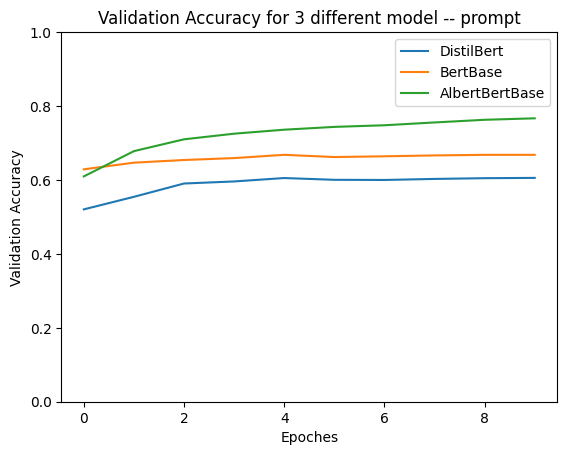

In [56]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
x1 = range(10)
y1 = validation_accuracy_distil_bert

x2 = range(10)
y2 = validation_accuracy_bert_base

x3 = range(10)
y3 = validation_accuracy_albert_bert_base

# Create the plot
plt.plot(x1, y1, label="DistilBert")
plt.plot(x2, y2, label="BertBase")
plt.plot(x3, y3, label="AlbertBertBase")

# Set y-axis limits to 0 and 1
plt.ylim(0, 1)

# Set labels for axes
plt.xlabel("Epoches")
plt.ylabel("Validation Accuracy")

# Add a title (optional)
plt.title("Validation Accuracy for 3 different model -- prompt")

# Add a legend
plt.legend()

# Show the plot
plt.show()


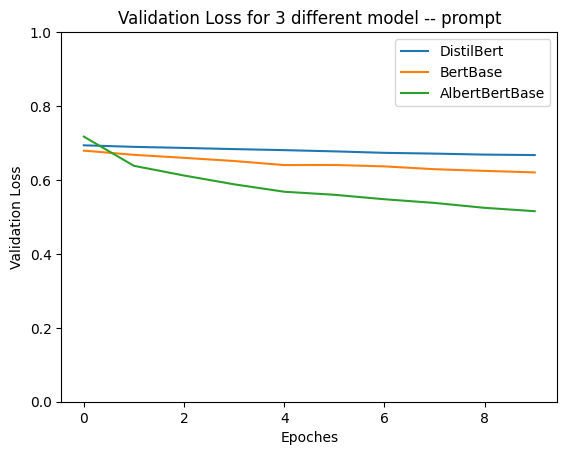

In [57]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
x1 = range(10)
y1 = loss_distilbrer

x2 = range(10)
y2 = loss_bert_base

x3 = range(10)
y3 = loss_albert_bert_base

# Create the plot
plt.plot(x1, y1, label="DistilBert")
plt.plot(x2, y2, label="BertBase")
plt.plot(x3, y3, label="AlbertBertBase")

# Set y-axis limits to 0 and 1
plt.ylim(0, 1)

# Set labels for axes
plt.xlabel("Epoches")
plt.ylabel("Validation Loss")

# Add a title (optional)
plt.title("Validation Loss for 3 different model -- prompt")

# Add a legend
plt.legend()

# Show the plot
plt.show()
